In [45]:
import matplotlib.pyplot as plt

import config
from dataset import OCRDataset
from utils import *

In [46]:
root_dir = '../../data/komonjo/200003076/'
path_to_annotation_csv = root_dir + '200003076_coordinate.csv'
original_image_dir = root_dir + 'images/'
resized_image_dir = root_dir + 'images_resized_320/'

In [47]:
preprocessed_annotation = preprocess_annotation(path_to_annotation_csv, original_image_dir)

utf16_to_index, index_to_utf16 = make_maps_between_index_and_frequent_characters_utf16(preprocessed_annotation, 
                                                                                       config.N_KINDS_OF_CHARACTERS)

selected_annotation = select_annotation_and_convert_ut16_to_index(preprocessed_annotation, utf16_to_index)

dataset = OCRDataset(resized_image_dir, selected_annotation)

In [50]:
index = 0
image, label = dataset.__getitem__(index)
bboxes = dataset.label2bboxes(label)

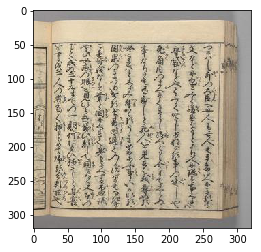

In [51]:
plt.imshow(image)